In [2]:
#!pip install scikit-learn

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, recall_score, roc_curve, auc

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import timm

In [2]:
#model = timm.create_model("swin_tiny_patch4_window7_224")
#all_pretrained_models_available = timm.list_models(pretrained=True)
#print(all_pretrained_models_available)
#print(len(all_pretrained_models_available))

In [3]:

# Set device
# It sets the device to GPU if available, otherwise to CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")# 检查是否支持CUDA，设置设备为GPU或CPU

# Load pretrained Swin Transformer model
# It loads the pretrained Swin Transformer model with the specified architecture ("swin_tiny_patch4_window7_224") and sets the number of classes to 6.
model = timm.create_model("swin_tiny_patch4_window7_224", pretrained=False, num_classes=6).to(device)

# Load the pre-trained model's state dictionary
# It loads the state dictionary of the pretrained model from a file.
pretrained_model_path = "swin_tiny_patch4_window7_224.pth"
pretrained_state_dict = torch.load(pretrained_model_path, map_location=torch.device('cuda'))['model']

# Change the output layer's weights and biases to match your model's output layer size
# It modifies the output layer's weights and biases in the state dictionary to match the number of classes in your model.
pretrained_state_dict['head.weight'] = pretrained_state_dict['head.weight'][:6, :]
pretrained_state_dict['head.bias'] = pretrained_state_dict['head.bias'][:6]

# Load the modified state dictionary into your model
# It loads the modified state dictionary into your model.
model.load_state_dict(pretrained_state_dict)

/root/miniconda3/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<All keys matched successfully>

In [4]:
# Data preprocessing and augmentation
# It defines data preprocessing and augmentation transformations using the transforms.Compose function. The transformations include resizing the images to (224, 224), random horizontal flipping, converting the images to tensors, and normalizing the pixel values.
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets
# It loads the training, validation, and test datasets using the datasets.ImageFolder class, specifying the data directory and the defined transformations.
data_dir = "datas"
train_data = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform)
val_data = datasets.ImageFolder(os.path.join(data_dir, "validation"), transform=transform)
test_data = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform)

# It creates data loaders for the training, validation, and test datasets using the DataLoader class, specifying the batch size and whether to shuffle the data.
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


In [28]:
# Set loss function and optimizer
# It sets up the loss function as cross-entropy loss and the optimizer as Adam optimizer, with a learning rate of 1e-4.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training and validation
# It initializes empty lists to store the training and validation accuracy history.
# It loops over each epoch.
num_epochs = 20
train_acc_history = []
val_acc_history = []

for epoch in range(num_epochs):
    
    # Training
    model.train()
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_acc = train_correct / train_total
    train_acc_history.append(train_acc)

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    val_outputs_list = []
    val_labels_list = []
    val_loss = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
            val_outputs_list.append(outputs.cpu().numpy())
            val_labels_list.append(labels.cpu().numpy())

        val_acc = val_correct / val_total
        val_acc_history.append(val_acc)

        # Calculate average validation loss
        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val Loss: {avg_val_loss:.4f}")
        

Epoch 1/20, Train Acc: 0.9920, Val Acc: 0.1680, Val Loss: 12.4497
Epoch 2/20, Train Acc: 0.9888, Val Acc: 0.1693, Val Loss: 8.7084
Epoch 3/20, Train Acc: 0.9923, Val Acc: 0.1680, Val Loss: 11.0080
Epoch 4/20, Train Acc: 0.9894, Val Acc: 0.1654, Val Loss: 9.8893
Epoch 5/20, Train Acc: 0.9968, Val Acc: 0.1667, Val Loss: 12.1801
Epoch 6/20, Train Acc: 0.9936, Val Acc: 0.1654, Val Loss: 11.2770
Epoch 7/20, Train Acc: 0.9913, Val Acc: 0.1641, Val Loss: 10.5157
Epoch 8/20, Train Acc: 0.9942, Val Acc: 0.1680, Val Loss: 10.1567
Epoch 9/20, Train Acc: 0.9955, Val Acc: 0.1667, Val Loss: 11.3570
Epoch 10/20, Train Acc: 0.9923, Val Acc: 0.1654, Val Loss: 10.5984
Epoch 11/20, Train Acc: 0.9891, Val Acc: 0.1680, Val Loss: 11.9741
Epoch 12/20, Train Acc: 0.9971, Val Acc: 0.1680, Val Loss: 11.9269
Epoch 13/20, Train Acc: 0.9971, Val Acc: 0.1628, Val Loss: 12.0206
Epoch 14/20, Train Acc: 0.9942, Val Acc: 0.1654, Val Loss: 13.0734
Epoch 15/20, Train Acc: 0.9936, Val Acc: 0.1641, Val Loss: 10.3962
Epoch 

In [33]:
#保存模型参数
torch.save(model.state_dict(), "swin_model.pth")

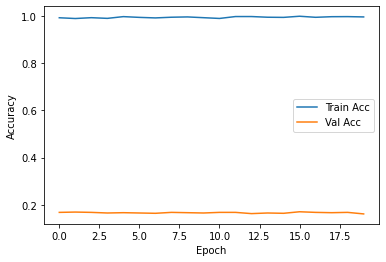

In [34]:
plt.figure()
plt.plot(train_acc_history, label="Train Acc")
plt.plot(val_acc_history, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [35]:
# import os
# import numpy as np
# import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
# from torchvision import transforms, datasets
# from torch.utils.data import DataLoader

# import torch
# import torch.nn as nn
# import timm

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the saved model
model = timm.create_model("swin_tiny_patch4_window7_224", pretrained=False, num_classes=6).to(device)
model.load_state_dict(torch.load("swin_model.pth"))
model.eval()

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): Sequential(
    (0): BasicLayer(
      dim=96, input_resolution=(56, 56), depth=2
      (blocks): ModuleList(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (a

Accuracy: 0.9723


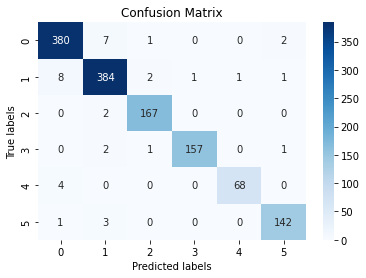

In [36]:
import seaborn as sns
# Create a data loader for the images
data_dir = "datas/test"
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_data = datasets.ImageFolder(data_dir, transform=transform)
data_loader = DataLoader(image_data, batch_size=1, shuffle=False)

# Predict and evaluate
y_true = []
y_pred = []
y_scores = []

with torch.no_grad():
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.append(labels.item())
        y_pred.append(predicted.item())
        y_scores.append(outputs.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
# y_pred = np.where(y_pred == 0, 1, 0)
y_scores = np.concatenate(y_scores, axis=0)

acc = accuracy_score(y_true, y_pred)

print(f"Accuracy: {acc:.4f}")

# Plot confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure()
#plt.imshow(conf_mat, cmap=plt.cm.Blues)
sns.heatmap(conf_mat,annot=True, fmt=".0f", cmap='Blues')
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

# get classification report
cr = classification_report(y_true, y_pred)

# print classification report
print(cr)


              precision    recall  f1-score   support

           0       0.97      0.97      0.97       390
           1       0.96      0.97      0.97       397
           2       0.98      0.99      0.98       169
           3       0.99      0.98      0.98       161
           4       0.99      0.94      0.96        72
           5       0.97      0.97      0.97       146

    accuracy                           0.97      1335
   macro avg       0.98      0.97      0.97      1335
weighted avg       0.97      0.97      0.97      1335

